In [1]:
# imports 
import emp_preprocessing as ep
import emp_fake_data as ef
import emp_metrics as em
import networkx as nx
import functions as fct
import numpy as np
import pandas as pd
import parameters as par
import os
import graphics as gx
import data_mapping as dm

import cpnet
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from tqdm import tqdm

#-----------
# parameters
plot_period=30
# market = "secured"
market = "unsecured"
path = f"./results/empirical_results/test_3/{market}/"

#------------------
# source files path

# from USB key
path_mmsr_secured = r'D:\MMSR_secured_small.dta'
path_mmsr_unsecured= r'D:\Unsecured_deposits_Small.dta'
path_finrep = r'D:\FINREP_Small.dta'

# # from NA laptop
# path_mmsr_secured = r'P:\ECB business areas\DGR\Databases and Programme files\FIR\Nolwenn Allaire\ABM - Le Coz\data\mmsr_all/MMSR_secured_small.dta'
# path_mmsr_unsecured= r'P:\ECB business areas\DGR\Databases and Programme files\FIR\Nolwenn Allaire\ABM - Le Coz\data\mmsr_all/Unsecured_deposits_Small.dta'
# path_finrep = r'P:\ECB business areas\DGR\Databases and Programme files\FIR\Nolwenn Allaire\ABM - Le Coz\results\Model Inputs\2. Bank Balance Sheet Statistics\balance_sheet_data_clean.dta'

# 1 data preprocessing

## 1.1  load input data

In [2]:
# get df_mmsr secured (used for transaction and exposure view)
df_mmsr_secured = pd.read_stata(path_mmsr_secured)
df_mmsr_secured.rename(columns=dm.dic_mmsr_secured_columns, inplace=True) # change the columns names 

# get df_mmsr unsecured (used for deposits time series)
df_mmsr_unsecured = pd.read_stata(path_mmsr_unsecured)

# build fake finrep data (used for accounting view)
df_finrep = pd.read_stata(path_finrep)
df_finrep.rename(columns=dm.dic_finrep_columns, inplace=True) # change the columns names 

## 1.2 build fake data

In [3]:
# nb_lines = int(1e2)

# # opt 2: get df_mmsr secured (used for transaction and exposure view)
# df_mmsr_secured = ef.get_df_mmsr_secured(nb_tran=nb_lines,holidays=dm.holidays)

# # get df_mmsr unsecured (used for deposits time series)
# df_mmsr_unsecured = ef.get_df_mmsr_unsecured(nb_tran=nb_lines,holidays=dm.holidays)

# # build fake finrep data (used for accounting view)
# df_finrep = ef.get_df_finrep()

## 1.3 preprocessing

### 1.3.1 anonymize & reduce size

In [ ]:
# data anonymization
df_mmsr_secured, df_mmsr_unsecured, df_finrep = ep.anonymize(df_mmsr_secured,df_mmsr_unsecured,df_finrep, path=path)

# data size reduction
ep.reduce_size(df_mmsr_secured,df_mmsr_unsecured, path)

### 1.3.2 clean & expand

In [ ]:
# # optional: to reload without re-anonymization
# df_mmsr_secured, df_mmsr_secured_clean, df_mmsr_secured_expanded, df_mmsr_unsecured, df_finrep_clean = ep.load_input_data_pickle(path=path)
# df_mmsr_secured.drop(columns = ["tenor", "end_step","start_step", "evergreen"], inplace=True)

In [ ]:
# get mmsr secured clean
df_mmsr_secured, df_mmsr_secured_clean = ep.get_df_mmsr_secured_clean(df_mmsr_secured, path=path, compute_tenor=True, flag_isin=True, sett_filter=True)

# print the share of evergreen transaction in the whole database
df_mmsr_secured_clean["evergreen"].value_counts(dropna=False)/len(df_mmsr_secured_clean)

In [ ]:
# get mmsr unsecured clean
mmsr_leis = df_mmsr_unsecured["report_agent_lei"].unique()
df_mmsr_unsecured_clean = df_mmsr_unsecured[df_mmsr_unsecured["cntp_lei"].isin(mmsr_leis)]

In [ ]:
# expand (either the unsecured of the secured market)
if market=="unsecured":
    df_expanded = get_df_expanded(
        df_clean=df_mmsr_unsecured_clean,
        holidays=False,
        path=False,
        lending=False,
        var_name="df_expanded",)

else:
    df_expanded = get_df_expanded(
        df_clean=df_mmsr_secured_clean,
        holidays=False,
        path=False,
        lending=False,
        var_name="df_expanded",)

In [ ]:
# get adj matrices from the expanded view

# get dic loan / rev_repo adjency matrices
dic_rev_repo_exp_adj = ep.get_dic_rev_repo_exp_adj_from_df_mmsr_secured_expanded(df_expanded,path=path, plot_period=False)

# get aggregated adjency matrices
dic_arr_binary_adj = ep.get_dic_arr_binary_adj(dic_rev_repo_exp_adj=dic_rev_repo_exp_adj,path=path, plot_period=plot_period)

In [ ]:
# transaciton view

# get df_rev_repo_trans
df_rev_repo_trans = ep.get_df_rev_repo_trans(df_mmsr_secured_clean, path=path)

In [ ]:
# dictionary of finrep across time

# get dic dashed trajectory
df_finrep_clean = ep.get_df_finrep_clean(df_finrep, path=path)
ep.add_ratios_in_df_finrep_clean(df_finrep_clean, path=path)
dic_dashed_trajectory = ep.get_dic_dashed_trajectory(df_finrep_clean,path=path)

### 1.3 test preprocessing bis for unsecured (not to run)

In [75]:
# test for unsecured


mmsr_leis = df_mmsr_unsecured["report_agent_lei"].unique()
df_test = df_mmsr_unsecured[df_mmsr_unsecured["cntp_lei"].isin(mmsr_leis)]

path = "./results/empirical_results/test_3/unsecured/"

def get_df_expanded(
    df_clean,
    holidays=False,
    path=False,
    lending=True,
    var_name=False,
):
    """
    This function creates a dataframw where each contract is repeated on each line for each day it is active.
    """

    print("get df_mmsr_secured_expanded")

    # filter only on the reverse repo i.e. lending cash (except user choose the oposite)
    if lending:
        df = df_clean[
            df_clean["trns_type"]
        ]
    else:
        df = df_clean[
            ~df_clean["trns_type"]
        ]
    df.drop("trns_type", axis=1, inplace=True)


    # get the max day from the max of the trade dates
    max_day = max(pd.to_datetime(df["trade_date"]))
    clipped_maturity_date = df["maturity_date"].clip(upper=max_day)

    # Create a list of dates for each contract
    if holidays:
        date_ranges = [
            pd.bdate_range(start, end, freq="C", holidays=holidays)
            for start, end in zip(df["trade_date"], clipped_maturity_date)
        ]
    else:
        date_ranges = [
            pd.date_range(start, end)
            for start, end in zip(df["trade_date"], clipped_maturity_date)
        ]

    # Duplicate rows based on date ranges
    df_expanded = df.loc[
        df.index.repeat([len(dates) for dates in date_ranges])
    ].copy()
    df_expanded["current_date"] = [
        date for dates in date_ranges for date in dates
    ]

    # Reset the index
    df_expanded.reset_index(drop=True, inplace=True)

    # save df_mmsr_secured_clean
    if path:
        df_expanded.to_csv(
            f"{path}pickle/{var_name}.csv"
        )
        pickle.dump(
            df_expanded,
            open(f"{path}pickle/{var_name}.pickle", "wb"),
            protocol=pickle.HIGHEST_PROTOCOL,
        )


    return df_expanded




df_mmsr_unsecured_expanded = get_df_expanded(
    df_clean=df_test,
    holidays=False,
    path=False,
    lending=False,
    var_name="df_mmsr_unsecured_expanded",)
dic_rev_repo_exp_adj = ep.get_dic_rev_repo_exp_adj_from_df_mmsr_secured_expanded(df_mmsr_unsecured_expanded,path=path, plot_period=False)

# get aggregated adjency matrices
dic_arr_binary_adj = ep.get_dic_arr_binary_adj(dic_rev_repo_exp_adj=dic_rev_repo_exp_adj,path=path, plot_period=plot_period)

# get df_rev_repo_trans
df_rev_repo_trans = ep.get_df_rev_repo_trans(df_mmsr_secured_clean, path=path)


get df_mmsr_secured_expanded
get dic_rev_repo_exp_adj from df_mmsr_secured_expanded


100%|██████████| 2468/2468 [00:09<00:00, 265.70it/s]


get dic_arr_binary_adj
get df_rev_repo_trans


## 1.4 pickle

In [7]:
# # imports 
# import emp_preprocessing as ep
# import emp_fake_data as ef
# import emp_metrics as em
# import networkx as nx
# import functions as fct
# import numpy as np
# import pandas as pd
# import parameters as par
# import os
# import graphics as gx
# import data_mapping as dm

# import cpnet
# import networkx as nx
# from matplotlib import pyplot as plt
# import seaborn as sns
# from matplotlib.colors import ListedColormap
# from tqdm import tqdm

# #-----------
# # parameters
# path = "./results/empirical_results/test_3/"
# plot_period=250

# # load input data
# df_mmsr_secured, df_mmsr_secured_clean, df_mmsr_secured_expanded, df_mmsr_unsecured, df_finrep_clean = ep.load_input_data_pickle(path=path)

# # pickle (faster)
# dic_arr_binary_adj = ep.load_dic_arr_binary_adj(path=path)
# dic_rev_repo_exp_adj = ep.load_dic_rev_repo_exp_adj(path=path)
# dic_dashed_trajectory = ep.load_dic_dashed_trajectory(path=path)
# df_rev_repo_trans = pd.read_csv(f"{path}pickle/df_rev_repo_trans.csv", index_col=0)

# 2 metrics measurement

In [16]:
os.makedirs(f"{path}accounting_view/", exist_ok=True)

### 2.1.2 accounting items

#### A - static, distribution across banks, at several point in time 

In [18]:
days = list(dic_rev_repo_exp_adj.keys())
plot_days = fct.list_intersection(days, dic_dashed_trajectory.keys())
bank_items = list(list(dic_dashed_trajectory.values())[0].columns)

# get df_powerlaw
df_powerlaw = em.get_powerlaw(
            dic_dashed_trajectory=dic_dashed_trajectory,
            days=days,
            plot_days=plot_days,
            plot_period=plot_period,
            path=f"{path}accounting_view/static/"
        )

# plot each powerlaw charts 
gx.plot_powerlaw(
            df_network_trajectory=df_powerlaw,
            days=days,
            plot_period=plot_period,
            path=f"{path}accounting_view/",
            plot_days=plot_days,
            bank_items=bank_items,
        )

# plot p-values across time 
gx.plot_network_trajectory(
                df=df_powerlaw,
                cols=[f"powerlaw p-value {bank_item}"  for bank_item in bank_items],
                file_name=f"{path}accounting_view/static/powerlaw_pvalue.pdf",
            )

# plot alpha of power laws across time 
gx.plot_network_trajectory(
                df=df_powerlaw,
                cols=[f"powerlaw alpha {bank_item}"  for bank_item in bank_items],
                file_name=f"{path}accounting_view/static/powerlaw_alpha.pdf",
            )

run power law tests


Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: Runti

#### B - dynamic, distribution across time

In [19]:
df_delta_deposits, df_relative_deposits, df_delta_deposits_over_assets = em.get_df_deposits(df_mmsr_unsecured, dic_dashed_trajectory)

get df_deposits


In [20]:
# distribution of deposits relative variation across time for each single bank
df_deposits_variations_by_bank = em.get_df_deposits_variations_by_bank(df_delta_deposits, df_relative_deposits, df_delta_deposits_over_assets, f"{path}/accounting_view/dynamic/")

df = df_deposits_variations_by_bank[df_deposits_variations_by_bank>0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/dynamic/per_bank/positive/", transverse=True)

df = -df_deposits_variations_by_bank[df_deposits_variations_by_bank<0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/dynamic/per_bank/negative/", transverse=True)

get df_deposits_variations_by_bank


Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value 

#### C - mixed view across time and banks

In [21]:
# distribution of deposits relative variation across time for each single bank
df_deposits_variations = em.get_df_deposits_variations(df_delta_deposits, df_relative_deposits, df_delta_deposits_over_assets, f"{path}/accounting_view/mixed/")

df = df_deposits_variations[df_deposits_variations>0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/mixed/positive/")

df = -df_deposits_variations[df_deposits_variations<0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/mixed/negative/")

get df_deposits_variation


Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\li

## 2.2. exposure view

In [77]:
path

'./results/empirical_results/test_3/unsecured/'

In [78]:
os.makedirs(f"{path}exposure_view/", exist_ok=True)

### 2.2.1 jaccard

In [79]:
days = list(dic_rev_repo_exp_adj.keys())

# get jaccard
df_jaccard = em.get_rev_repo_exposure_stats(dic_arr_binary_adj, days, path=f"{path}exposure_view/")
gx.plot_network_trajectory(
            df=df_jaccard,
            cols=df_jaccard.columns,
            file_name=f"{path}exposure_view/jaccard_index.pdf")

get jaccard


100%|██████████| 2467/2467 [00:00<00:00, 3506.71it/s]


### 2.2.2 density

In [80]:
days = list(dic_rev_repo_exp_adj.keys())

# get density
df_density = em.get_density(dic_arr_binary_adj, days, path=f"{path}exposure_view/")
gx.plot_network_trajectory(
            df=df_density,
            cols=df_density.columns,
            file_name=f"{path}exposure_view/network_density.pdf",
        )

get density


100%|██████████| 2467/2467 [00:00<00:00, 3437.82it/s]


### 2.2.3 degree distribution  (static)

In [81]:
days = list(dic_rev_repo_exp_adj.keys())

# get degree distribution
dic_in_degree, dic_out_degree, dic_degree = em.get_degree_distribution(dic_arr_binary_adj, path=f"{path}exposure_view/degree_distribution/")
gx.plot_degree_distribution(dic_in_degree,
    dic_out_degree,
    days,
    plot_period,
    f"{path}exposure_view/degree_distribution/")


get degree distribution


100%|██████████| 2468/2468 [00:02<00:00, 870.33it/s] 


### 2.2.4 degree stats

In [82]:
days = list(dic_rev_repo_exp_adj.keys())

# get av. degree
df_degree_stats = em.get_degree_stats(dic_degree, days, path=f"{path}exposure_view/")
gx.plot_network_trajectory(
            df=df_degree_stats,
            cols=df_degree_stats.columns,
            file_name=f"{path}exposure_view/degree_stats.pdf",
        )

get degree stats


100%|██████████| 2467/2467 [00:01<00:00, 1240.91it/s]


### 2.2.5 degree per asset

In [83]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(dic_rev_repo_exp_adj.values())[0].index

# select the days and banks (common between the 2 lists)
finrep_days = list(df_finrep_clean["qdate"])
finrep_bank_ids = list(set(df_finrep_clean["report_agent_lei"]))
plot_days = fct.list_intersection(days, finrep_days)

# plot
gx.plot_degree_per_asset(
    dic_dashed_trajectory,
    dic_degree,
    bank_ids,
    days,
    plot_period,
    f"{path}exposure_view/degree_per_asset/",
    plot_days=plot_days,
    finrep_bank_ids=finrep_bank_ids)

### 2.2.6 network plots (static)

ValueError: s must be a scalar, or float array-like with the same size as x and y

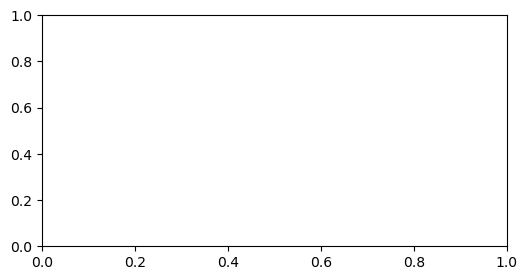

In [84]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(list(dic_rev_repo_exp_adj.values())[0].index)
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
plot_days = fct.list_intersection(days, dic_dashed_trajectory.keys())

# plot the reverse repo network
gx.plot_weighted_adj_network(
    arr_rev_repo_exp_adj,
    dic_dashed_trajectory,
    days,
    plot_period,
    f"{path}exposure_view/weighted_adj_network/",
    "reverse repo",
    bank_ids=bank_ids,
    plot_days=plot_days,
)

### 2.2.6 core periphery (static)

In [87]:
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
days = list(dic_rev_repo_exp_adj.keys())

# get df_cpnet
df_cpnet = em.get_cpnet(
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/core-periphery/",
            )

# Plot the core-periphery struture
gx.plot_cpnet(
                df_network_trajectory=df_cpnet,
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/",
            )

# # read csv (faster)
# df_cpnet = pd.read_csv(f"{path}exposure_view/core-periphery/df_cpnet.csv", index_col=0)
# df_cpnet.index = pd.to_datetime(df_cpnet.index)

# plot the time evolution of p-values for each aggregation level
for fig in par.figs_cpnet_pvalues:
    gx.plot_network_trajectory(
            df=df_cpnet,
            cols=fig[1],
            file_name=f"{path}{fig[0]}.pdf",
        )

run core-periphery tests


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the KM_ER approach
test on day 2016-03-29 00:00:00
test on day 2016-04-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 100.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 50.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 20.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 15.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 16.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 19.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 47.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 53.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 79.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 57.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 47.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 16.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 60.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 64.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 33.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 45.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 45.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 53.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 53.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 72.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 66.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 93.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 92.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 78.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 66.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 51.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 63.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 82.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 56.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 60.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 65.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 63.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 76.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the KM_config approach
test on day 2016-03-29 00:00:00
test on day 2016-04-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 52.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 57.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 58.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 50.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 55.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 79.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 54.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 67.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 52.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 61.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 49.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 47.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 47.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 19.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 23.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 49.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 64.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
 59%|█████▉    | 59/100 [00:00<00:00, 82.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 169.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 86.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 83.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 92.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 33.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:146: RuntimeWarning: overflow encountered in exp
  denom = sum(np.exp(logw - ave_logw))
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:148: RuntimeWarning: overflow encountered in exp
  w = np.exp(logw)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:151: RuntimeWarning: invalid value encountered in scalar divide
  p_values[cid] = 1.0 - (sum(w * cd) / denom)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix 

test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 65.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:146: RuntimeWarning: overflow encountered in exp
  denom = sum(np.exp(logw - ave_logw))
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:148: RuntimeWarning: overflow encountered in exp
  w = np.exp(logw)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:151: RuntimeWarning: invalid value encountered in scalar divide
  p_values[cid] = 1.0 - (sum(w * cd) / denom)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix 

test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 47.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 55.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:146: RuntimeWarning: overflow encountered in exp
  denom = sum(np.exp(logw - ave_logw))
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:148: RuntimeWarning: overflow encountered in exp
  w = np.exp(logw)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:151: RuntimeWarning: invalid value encountered in scalar divide
  p_values[cid] = 1.0 - (sum(w * cd) / denom)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix 

test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 56.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:146: RuntimeWarning: overflow encountered in exp
  denom = sum(np.exp(logw - ave_logw))
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:148: RuntimeWarning: overflow encountered in exp
  w = np.exp(logw)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:151: RuntimeWarning: invalid value encountered in scalar divide
  p_values[cid] = 1.0 - (sum(w * cd) / denom)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix 

core-periphery tests using the Rombach approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 278.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 265.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 245.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 256.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 263.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 263.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 277.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 275.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 278.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 296.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 277.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 248.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 286.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 284.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 276.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 268.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 275.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 257.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 289.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 267.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 286.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 267.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 279.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 301.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 283.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 270.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 274.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 287.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 257.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 246.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 277.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 257.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 297.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 296.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 283.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 287.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 285.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 286.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 266.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 264.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 284.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 278.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 275.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 265.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 292.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 289.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 281.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 241.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 203.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 224.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 178.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 253.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 294.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 306.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 275.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 300.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 284.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 331.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 304.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 314.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 307.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 318.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 293.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 262.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 239.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 273.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 283.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 266.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 262.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 273.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 269.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 224.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 106.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 267.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 297.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 309.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 288.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 293.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 302.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 307.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 300.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 318.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 320.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the Rossa approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.10it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 145.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 145.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 143.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 74.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 112.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 147.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 144.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 147.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 148.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 149.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 148.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 148.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 145.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 147.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 149.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 148.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 144.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 147.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 142.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 145.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 148.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 148.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 149.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 145.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 147.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 144.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 143.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 144.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 144.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 145.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 144.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 148.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 145.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 145.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 147.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 145.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 143.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 149.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 148.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 147.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 143.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 104.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 112.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the LapCore approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 118.45it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 125.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 142.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the LapSgnCore approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 559.10it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 501.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 358.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 362.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 307.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 408.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 407.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 419.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 448.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 457.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 479.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 385.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 370.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 444.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 445.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 476.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 463.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 459.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 431.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 430.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 467.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 393.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 413.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 392.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 446.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 473.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 444.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 474.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 454.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 462.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 392.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 460.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 467.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 487.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 476.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 402.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 421.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 445.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 437.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 415.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 448.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 449.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 441.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 402.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 420.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 454.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 380.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 467.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 459.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 440.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 449.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 427.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 456.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 460.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 474.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 459.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 487.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 456.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 505.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 534.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 515.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 497.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 421.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 519.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 502.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 483.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 462.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 505.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 530.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 463.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 387.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 477.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 483.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 472.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 458.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 483.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 455.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 388.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 441.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 466.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 472.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 470.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 502.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 502.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the LowRankCore approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 144.82it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 132.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.95it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 45.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 92.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 79.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 59.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 75.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 65.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 70.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 68.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 73.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 74.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 70.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 73.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 84.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 66.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 63.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 73.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the MINRES approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.87it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:02<00:00, 43.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 45.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 48.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 48.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 49.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 49.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 49.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 48.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 47.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 49.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 47.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 49.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 47.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 48.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 45.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the Lip approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 2701.73it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1870.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1603.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1567.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1505.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1701.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1002.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1641.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1631.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1694.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1773.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1614.40it/s]

test on day 2017-03-24 00:00:00



c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1657.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjace

test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1746.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 868.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1604.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1691.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1702.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1582.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1704.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1847.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1055.95it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1669.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1693.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1734.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1834.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1695.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1914.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1727.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1736.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 911.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1462.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1633.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1536.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1736.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1640.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1623.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1691.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 873.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1537.90it/s]

test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1579.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1601.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1605.79it/s]


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1696.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacen

test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1629.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 902.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1793.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1744.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1620.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1723.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1708.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1689.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1151.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1670.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1793.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1794.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1867.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1891.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1990.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 942.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1966.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 2002.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 2153.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 2298.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 2030.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 2254.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1266.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1807.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 2044.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 2198.75it/s]

test on day 2021-12-28 00:00:00



c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1970.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjace

test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 2036.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1973.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1180.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1655.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1851.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1836.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1820.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1648.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1687.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1849.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1366.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1474.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1985.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the BE approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1243.76it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 190.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 172.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 159.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 159.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 190.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 184.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 198.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 195.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 207.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 185.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 159.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 176.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 150.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 172.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 168.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 159.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 172.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 161.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 161.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 176.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 171.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 170.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 143.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 159.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 168.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 163.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 168.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 152.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 173.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 179.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 171.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 188.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 185.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 161.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 177.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 169.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 174.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 173.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 171.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 182.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 159.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 171.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 156.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 197.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 170.95it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 178.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 173.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 177.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 163.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 180.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 171.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 166.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 150.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 178.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 184.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 211.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 192.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 209.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 194.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 189.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 194.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 199.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 196.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 206.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 190.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 194.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 200.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 208.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 191.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 183.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 169.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 172.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 166.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 184.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 176.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 179.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 182.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 175.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 174.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 184.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
 20%|██        | 1/5 [16:35<1:06:22, 995.74s/it]c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the KM_ER approach
test on day 2016-03-29 00:00:00
test on day 2016-04-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 87.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 13.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 12.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:08<00:00, 12.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 12.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 14.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 14.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 14.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 20.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 16.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 14.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 54.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:08<00:00, 11.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 16.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 81.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 19.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 50.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 49.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 19.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 19.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 49.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.95it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 90.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 80.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 79.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 217.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 209.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 219.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 205.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 203.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 218.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 220.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 238.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 173.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 180.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 163.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 190.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 87.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 62.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 65.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 81.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 56.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 50.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 64.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 66.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 73.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the KM_config approach
test on day 2016-03-29 00:00:00
test on day 2016-04-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 52.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 65.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 48.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 57.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 48.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 51.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 33.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 16.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 33.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 68.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 154.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 169.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 143.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 112.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 57.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 50.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:146: RuntimeWarning: overflow encountered in exp
  denom = sum(np.exp(logw - ave_logw))
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:148: RuntimeWarning: overflow encountered in exp
  w = np.exp(logw)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:151: RuntimeWarning: invalid value encountered in scalar divide
  p_values[cid] = 1.0 - (sum(w * cd) / denom)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix 

test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


core-periphery tests using the Rombach approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 246.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 236.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 237.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 241.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 236.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 196.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 207.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 225.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 191.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 240.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 229.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 226.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 218.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 257.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 243.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 268.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 197.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 268.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 239.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 272.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 221.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 257.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 267.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 230.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 264.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 247.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 259.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 269.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 260.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 263.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 228.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 266.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 237.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 220.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 265.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 252.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 229.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 272.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 228.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 259.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 241.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 216.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 259.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 260.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 270.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 232.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 273.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 277.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 286.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 273.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 236.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 254.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 265.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 266.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 261.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 286.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 274.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 284.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 302.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 286.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 262.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 290.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 286.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 298.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 304.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 274.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 292.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 287.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 290.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 291.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 300.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 297.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 250.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 268.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 276.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 242.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 263.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 282.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 274.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 282.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 259.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 274.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 286.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the Rossa approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.45it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 125.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 99.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 142.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 142.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 144.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 143.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 118.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 106.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 106.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 103.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 102.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 106.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 108.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the LapCore approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 102.98it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 103.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 79.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 85.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 91.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 88.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 91.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 101.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 100.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 112.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 96.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 86.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 98.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 105.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 92.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 90.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 95.95it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 97.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 90.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 100.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 95.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 92.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 118.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 110.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 110.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.95it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 93.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 104.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 106.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 101.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the LapSgnCore approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 522.59it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 306.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 298.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 283.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 302.95it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 210.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 218.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 252.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 286.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 326.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 231.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 317.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 281.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 329.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 333.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 339.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 301.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 288.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 348.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 348.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 314.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 297.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 389.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 338.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 270.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 383.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 338.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 344.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 372.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 347.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 229.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 277.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 344.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 320.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 298.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 286.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 308.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 238.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 319.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 271.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 323.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 351.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 297.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 275.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 276.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 147.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 168.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 168.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 249.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 164.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 165.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 143.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 159.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 167.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 219.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 246.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 203.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 227.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 190.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 213.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 181.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 210.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 235.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 211.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 219.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 217.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 277.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 244.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 244.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 191.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 201.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 234.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 184.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 189.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 209.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 163.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 249.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 189.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 432.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 430.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 428.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 386.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 460.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the LowRankCore approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 145.56it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 128.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 108.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 110.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 101.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 106.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 110.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 101.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 105.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 118.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 105.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 103.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the MINRES approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.21it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:04<00:00, 22.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 19.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 23.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 23.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 45.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 19.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 45.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 23.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 13.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 33.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the Lip approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 2143.14it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1231.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1201.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 624.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1040.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1061.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1081.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1166.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1256.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1328.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 828.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1231.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1281.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1221.71it/s]

test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1363.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1257.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1290.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1550.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1448.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1420.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1421.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1506.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1650.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1469.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1464.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1696.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1538.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1395.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 861.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1303.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1413.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1454.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 816.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1121.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1482.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1378.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 865.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1328.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1390.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 744.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1224.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1422.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1406.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 833.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 187.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1471.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1411.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 828.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1422.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1562.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1291.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 754.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1008.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1115.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1011.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1242.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1242.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 630.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1342.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1586.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1590.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 971.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1488.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1581.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1641.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1113.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1346.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1649.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1744.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1832.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 783.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1769.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1660.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 843.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1456.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1465.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1405.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1474.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1490.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1622.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 842.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1548.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1439.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1666.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the BE approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 1043.09it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 156.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 143.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 149.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 155.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 149.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 110.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 156.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 158.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 168.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 152.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 154.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 142.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 162.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 166.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 164.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 163.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 141.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 151.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 161.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 161.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 176.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 145.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 149.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 159.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 151.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 161.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 160.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 161.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 152.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 167.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 149.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 163.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 165.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 170.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 167.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 146.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 165.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 174.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 177.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 182.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 206.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 175.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 198.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 173.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 147.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 165.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 184.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 178.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 148.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 176.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 164.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 151.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 178.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 180.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 183.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 179.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 180.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 175.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 168.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 173.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 175.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 178.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
 40%|████      | 2/5 [35:02<53:03, 1061.00s/it] c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the KM_ER approach
test on day 2016-03-29 00:00:00
test on day 2016-04-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 89.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 16.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 13.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:10<00:00,  9.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:14<00:00,  6.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:13<00:00,  7.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:09<00:00, 10.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:09<00:00, 10.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:08<00:00, 11.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:08<00:00, 11.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 13.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:08<00:00, 12.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:08<00:00, 12.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 12.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 15.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 14.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 16.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 14.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 13.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 14.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 14.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 15.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 14.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 15.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 13.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 16.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 17.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 20.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 19.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 17.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 16.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 13.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 15.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 15.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:07<00:00, 14.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 17.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 20.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 50.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 75.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 82.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 104.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 85.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 191.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 166.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 151.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 167.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 157.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.69it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 152.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 69.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 95.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 59.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 64.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 63.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 51.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 50.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 51.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 46.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the KM_config approach
test on day 2016-03-29 00:00:00
test on day 2016-04-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 23.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 33.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 23.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 18.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:06<00:00, 16.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 25.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 23.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 33.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 43.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 26.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 23.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 30.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 32.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 100.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 131.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 72.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 108.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 142.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 42.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 33.33it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 44.75it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 31.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 21.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 40.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:146: RuntimeWarning: overflow encountered in exp
  denom = sum(np.exp(logw - ave_logw))
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:148: RuntimeWarning: overflow encountered in exp
  w = np.exp(logw)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:151: RuntimeWarning: invalid value encountered in scalar divide
  p_values[cid] = 1.0 - (sum(w * cd) / denom)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix 

test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.95it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 41.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 34.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 22.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:04<00:00, 24.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 28.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 27.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


core-periphery tests using the Rombach approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 286.46it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 219.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 236.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 224.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 227.36it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 219.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 224.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 214.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 233.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 224.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 216.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 253.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 247.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 223.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 260.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 257.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 271.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 277.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 212.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 246.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 255.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 268.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 266.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 255.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 239.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 267.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 268.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 232.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 264.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 254.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 231.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 251.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 249.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 236.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 262.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 251.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 221.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 248.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 268.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 268.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 264.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 237.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 264.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 220.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 248.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 246.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 220.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 255.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 260.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 234.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 270.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 266.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 234.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 261.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 265.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 254.77it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 248.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 292.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 243.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 270.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 300.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 264.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 289.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 302.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 257.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 303.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 318.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 257.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 293.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 240.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 217.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 265.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 289.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 249.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 295.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 296.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 261.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 284.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 277.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 243.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 275.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 276.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 266.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the Rossa approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 139.55it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 129.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 132.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.51it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.61it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 118.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 129.02it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 138.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 126.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 134.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 133.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 101.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 110.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 100.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 95.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 83.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 88.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 100.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 107.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 86.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 53.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 48.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 67.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 66.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 57.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 61.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 52.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 57.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 70.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 62.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 64.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 66.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 56.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 53.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 65.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 60.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 66.83it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:03<00:00, 29.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 47.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 72.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 50.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 59.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 56.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 54.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 37.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:05<00:00, 17.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 35.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 53.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 67.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 72.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 58.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 76.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 72.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 66.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 135.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 140.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 136.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the LapCore approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 137.57it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 105.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 108.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 108.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 96.08it/s] 
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 104.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 101.95it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.64it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 108.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 98.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 98.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 107.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.05it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 112.23it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 118.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 110.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 110.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.24it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 105.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 106.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 101.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 102.22it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 115.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 110.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 98.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 112.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 102.91it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 106.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 106.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.10it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 125.04it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 117.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.56it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 130.35it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.94it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 123.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 128.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 122.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 124.07it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 110.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 108.84it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 114.00it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 119.29it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 120.82it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 116.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the LapSgnCore approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 402.34it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 282.25it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 296.97it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 267.76it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 256.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 264.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 207.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 231.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 280.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 291.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 220.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 156.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 282.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 210.87it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 256.50it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 263.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 274.12it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 200.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 215.96it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 248.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 241.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 259.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 262.52it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 274.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 339.74it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 271.88it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 261.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 288.15it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 305.73it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 256.37it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 303.63it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 282.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 326.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 335.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 339.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 277.13it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 342.21it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 250.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 307.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 281.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-07-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 313.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-08-11 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 292.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-09-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 260.49it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-10-10 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 350.44it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-11-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 297.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-12-09 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 256.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-01-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 303.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-02-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 336.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-03-08 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 268.81it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-04-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 221.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-05-07 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 349.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-06-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 289.66it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-07-06 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 348.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-08-05 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 350.34it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-09-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 368.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-10-04 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 392.68it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-11-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 301.72it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2020-12-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 402.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-01-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 371.20it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-02-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 121.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-03-03 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 380.57it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-04-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 238.71it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-05-02 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 399.30it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-06-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 358.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-01 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 439.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-07-31 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 415.26it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-08-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 305.32it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-09-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 431.43it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-10-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 458.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-11-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 464.80it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2021-12-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 466.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-01-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 476.48it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-02-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 471.70it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-03-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 355.47it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-04-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 448.31it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-05-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 448.85it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-06-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 335.39it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-07-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 432.38it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-08-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 364.42it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-09-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 269.40it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-10-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 380.16it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-11-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 396.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 291.86it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2022-12-30 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 369.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


core-periphery tests using the LowRankCore approach
test on day 2016-03-29 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 127.61it/s]


test on day 2016-04-28 00:00:00


100%|██████████| 100/100 [00:00<00:00, 127.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-05-28 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.60it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-06-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.09it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-07-27 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 92.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-08-26 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 101.06it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-09-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 97.98it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-10-25 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 106.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-11-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 94.11it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2016-12-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 111.08it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-01-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 113.79it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-02-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:00<00:00, 109.18it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-03-24 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 47.45it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-04-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 38.59it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-05-23 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 36.92it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-06-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:02<00:00, 39.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-07-22 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 61.78it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-08-21 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 87.41it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-09-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 93.65it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-10-20 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 70.14it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-11-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 87.55it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2017-12-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 83.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-01-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 92.53it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-02-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 79.17it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-03-19 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 74.28it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-04-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 88.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-05-18 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 88.19it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-06-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 90.67it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-07-17 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 92.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-08-16 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 80.58it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-09-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 72.89it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-10-15 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 78.54it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-11-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 87.27it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2018-12-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 84.93it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-01-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 82.90it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-02-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 86.62it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-03-14 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 94.03it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-04-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 87.01it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-05-13 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))
100%|██████████| 100/100 [00:01<00:00, 80.99it/s]
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:96: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


test on day 2019-06-12 00:00:00


c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\cpnet\qstest.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Ar = sparse.csr_matrix(nx.adjacency_matrix(Gr))


## 2.3 transaction view

In [ ]:
os.makedirs(f"{path}transaction_view/", exist_ok=True)

### 2.3.1 av network

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())
df_transaction_stats = em.get_transaction_stats(
            df_rev_repo_trans=df_rev_repo_trans,
            extension=" av. network",
            days=days,
            path=f"{path}transaction_view/",
        )

# plot the time evolution of the av network trans level metrics
for fig in [par.fig_repo_transactions_maturity_av_network, par.fig_repo_transactions_notional_av_network, par.fig_number_repo_transactions_av_network]:
    gx.plot_network_trajectory(
            df=df_transaction_stats,
            cols=fig[1],
            file_name=f"{path}{fig[0]}.pdf",
        )

get transaction stats av. network


100%|██████████| 2548/2548 [00:21<00:00, 118.87it/s]


### 2.3.2 reverse repos by notice period (static)

#### A - Static

In [ ]:
# plot notional by notice period
gx.plot_notional_by_notice_period(df_expanded, path=f"{path}transaction_view/", plot_period=plot_period)

#### A - Dynamic 

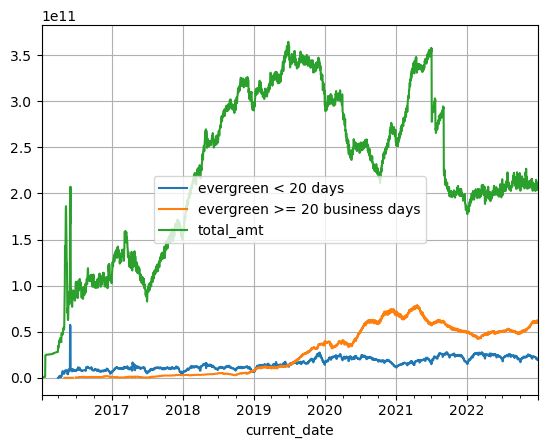

In [ ]:
# plot the total amount of repo by tenor and type
df = df_expanded[["current_date","tenor","evergreen","trns_nominal_amt"]][df_expanded["evergreen"]]
df["evergreen >= 20 days"] = df["tenor"] >= 20
df = df.groupby(["evergreen >= 20 days","current_date"]).agg({"trns_nominal_amt":sum}).unstack(level="evergreen >= 20 days")
df = df.droplevel(0,axis=1)
df.columns.name = None
df.rename(columns={True:"evergreen >= 20 business days",False:"evergreen < 20 days"}, inplace=True)
ax = df.plot()
df_expanded.groupby(["current_date"]).agg(
    total_amt=("trns_nominal_amt",sum)).plot(ax=ax)
plt.grid()


### 2.3.3 colletral ising code reuse

#### A - Static

In [ ]:
df_isin = em.get_df_isin(df_expanded, path=f"{path}transaction_view/")
gx.plot_collateral_reuse(df_isin=df_isin, path=f"{path}transaction_view/", plot_period=plot_period)

#### B - Dynamic

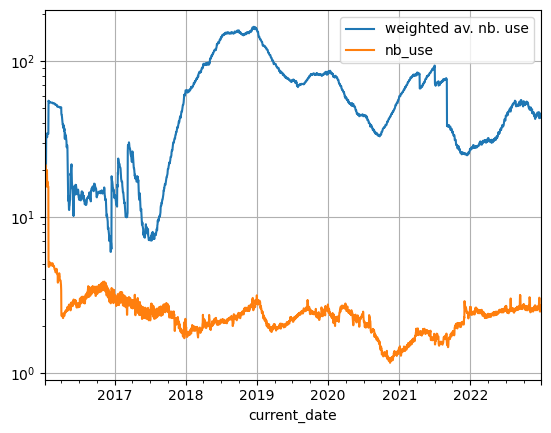

In [ ]:
df = df_isin[["nb_use","total_amt"]]
df["prod_nb_use"] = df["nb_use"]*df["total_amt"]
df_grouped = df.groupby(["current_date"]).agg({"prod_nb_use":sum,"total_amt":sum, "nb_use":"mean"})
df_grouped["weighted av. nb. use"] = df_grouped["prod_nb_use"] / df_grouped["total_amt"]
df_grouped[["weighted av. nb. use", "nb_use"]].plot()
plt.yscale("log")
plt.grid()

<Axes: xlabel='nb_use', ylabel='total_amt'>

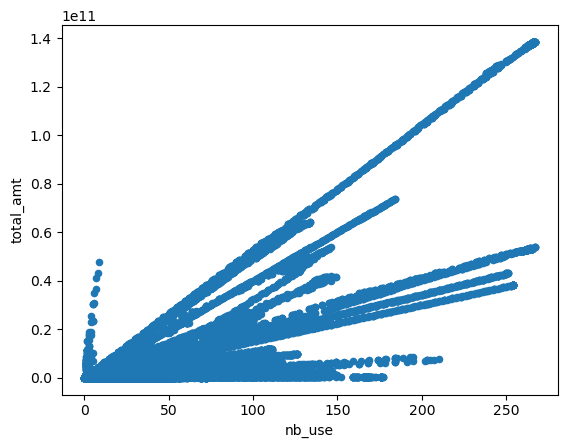

In [ ]:
df_isin.plot.scatter(x="nb_use", y="total_amt")

In [ ]:
df_isin.reset_index().groupby(["nb_use"]).agg({"coll_isin":tuple}).tail(50)

,coll_isin
nb_use,
218,"(ES0352506176, ES0352506135, ES0352506176, ES0..."
219,"(ES0352506176, ES0352506135, ES0352506234, XS0..."
220,"(ES0352506176, ES0352506176, ES0352506176, ES0..."
221,"(ES0352506176, ES0352506135, ES0352506135, ES0..."
222,"(ES0352506176, ES0352506135, ES0352506135, ES0..."
223,"(ES0352506176, ES0352506135, ES0352506176, ES0..."
224,"(ES0352506176, ES0352506135, ES0352506234, ES0..."
225,"(ES0352506176, ES0352506176, ES0352506176, ES0..."
226,"(ES0352506176, ES0352506135, ES0352506135, ES0..."


In [ ]:
df_isin.sort_values("nb_use",ascending=False)

nb_use     total_amt
current_date coll_isin                         
2018-11-30   ES0352506176     267  1.384031e+11
2019-12-17   ES0352506234     267  5.378748e+10
2019-12-18   ES0352506234     267  5.378748e+10
2018-11-12   ES0352506176     267  1.384364e+11
2018-11-26   ES0352506176     267  1.384031e+11
...                           ...           ...
2017-08-14   GB00B39J2M42       0  0.000000e+00
             GB00BD6K4575       0  0.000000e+00
2020-08-09   ES0157097017       0  0.000000e+00
             ES0167050915       0  0.000000e+00
2021-04-19   US28618M1062       0  0.000000e+00

[5272934 rows x 2 columns]

In [ ]:
df_isin

nb_use    total_amt
current_date coll_isin                        
2016-01-08   DE000A1ZZ028      23   30077180.0
             XS0490739686      20  193853640.0
2016-01-09   DE000A1ZZ028      23   30077180.0
             XS0490739686      20  193853640.0
2016-01-10   DE000A1ZZ028      23   30077180.0
...                           ...          ...
2022-12-30   XS2555198089       2    1740375.0
             XS2555209381       1     803728.0
             XS2555218291       1    1487740.0
             XS2558592932       2    1921760.0
             XS2559453431       1    2714040.0

[5272934 rows x 2 columns]

<Axes: xlabel='current_date'>

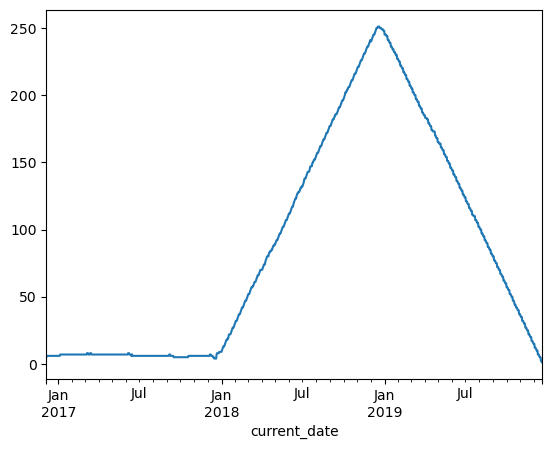

In [ ]:
df_isin.loc[:,"ES0352506135",:]["nb_use"].plot()

In [ ]:
test = df_mmsr_secured_clean[df_mmsr_secured_clean["coll_isin"]=="ES0352506135"]
test["line_id"] = test.index
test_grouped = test.groupby([
            "report_agent_lei",
            "cntp_lei",
            "tenor",
            "trns_nominal_amt",
            "coll_isin",
            "start_step",

        ]).agg({"line_id":tuple,"evergreen":tuple})

C:\Users\VictorLeCoz\AppData\Local\Temp\ipykernel_7296\1858524862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["line_id"] = test.index


In [ ]:
test_grouped.head(50)

line_id  \
report_agent_lei cntp_lei tenor trns_nominal_amt coll_isin    start_step               
741              4403     49.0  4.940408e+08     ES0352506135 256.0        (263935,)   
                          54.0  8.159522e+07     ES0352506135 703.0        (508773,)   
                          65.0  4.900670e+08     ES0352506135 303.0        (303571,)   
                          67.0  3.827977e+08     ES0352506135 432.0        (386337,)   
                                4.881320e+08     ES0352506135 367.0        (347940,)   
                          68.0  8.159250e+07     ES0352506135 637.0        (497821,)   
                 7166     13.0  4.500720e+08     ES0352506135 492.0        (413326,)   
                          65.0  4.500720e+08     ES0352506135 235.0        (178369,)   
                                                              298.0        (300052,)   
                          67.0  4.500720e+08     ES0352506135 427.0        (382993,)   
                          68.0  4.500720e+08     ES0352506135 361.0        (343493,)   
3405             9883     1.0   3.998800e+07     ES0352506135 695.0       (1049558,)   
                                4.998500e+07     ES0352506135 614.0       (1049560,)   
                                9.997000e+07     ES0352506135 577.0       (1049564,)   
                          2.0   9.997000e+07     ES0352506135 575.0        (430197,)   
                          3.0   3.998800e+07     ES0352506135 719.0        (430211,)   
                          193.0 9.977000e+07     ES0352506135 383.0        (209096,)   
4403             741      49.0  4.940408e+08     ES0352506135 256.0        (227920,)   
                          65.0  4.900670e+08     ES0352506135 303.0        (227908,)   
                          67.0  3.827977e+08     ES0352506135 432.0        (227903,)   
                                4.881320e+08     ES0352506135 367.0        (227926,)   
                          68.0  8.159250e+07     ES0352506135 637.0        (444309,)   
                 7964     271.0 1.715375e+08     ES0352506135 503.0        (190330,)   
                 13077    258.0 2.632844e+08     ES0352506135 503.0        (415204,)   
4506             9122     7.0   1.000068e+08     ES0352506135 624.0        (460248,)   
                                1.000262e+08     ES0352506135 619.0        (460234,)   
7166             741      130.0 4.500720e+08     ES0352506135 233.0         (47815,)   
                          272.0 4.500720e+08     ES0352506135 233.0         (47837,)   
                 10508    48.0  9.827922e+07     ES0352506135 458.0        (399437,)   
                          82.0  7.314605e+07     ES0352506135 503.0        (415107,)   
7964             4403     1.0   1.715375e+08     ES0352506135 519.0        (472091,)   
                                                              581.0        (485584,)   
                                                              646.0        (499170,)   
                                                              649.0        (499656,)   
                          256.0 1.715375e+08     ES0352506135 503.0        (415194,)   
                                                              506.0        (416256,)   
                                                              510.0        (470020,)   
                                                              515.0        (471164,)   
                                                              520.0        (472428,)   
                                                              525.0        (473538,)   
                                                              530.0        (474644,)   
                                                              535.0        (475578,)   
                                                              540.0        (476460,)   
                                                              545.0        (477304,)   
                             

# 3 tools

## examples of density / histogram in log - log

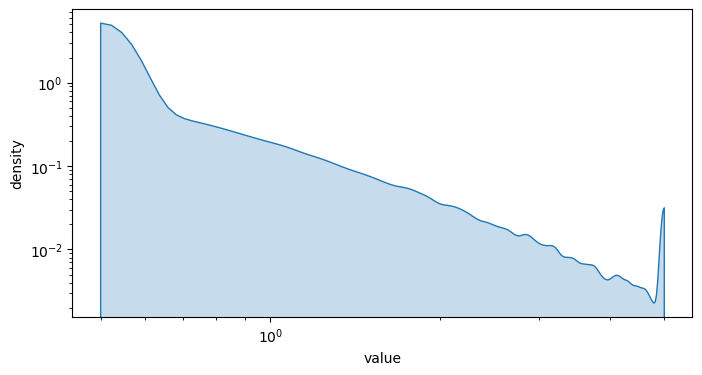

In [ ]:
# Pareto law

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.pareto(3,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(0.5,5), ax=ax, cut=0, fill=True)
ax.set_xscale('log')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('value')
ax.set_ylabel('density')

# Show the plot
plt.show()

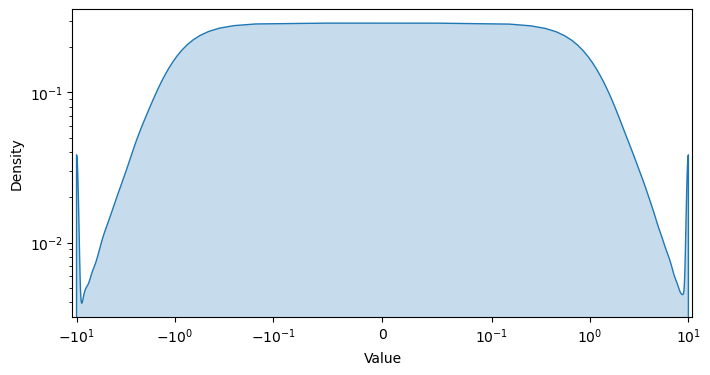

In [ ]:
# student law

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.standard_t(1,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(-10,10), ax=ax, fill=True, cut=0)
ax.set_xscale('symlog', linthresh=0.1)

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Value')
ax.set_ylabel('Density')

# Show the plot
plt.show()

## multiple histogram on the same plot

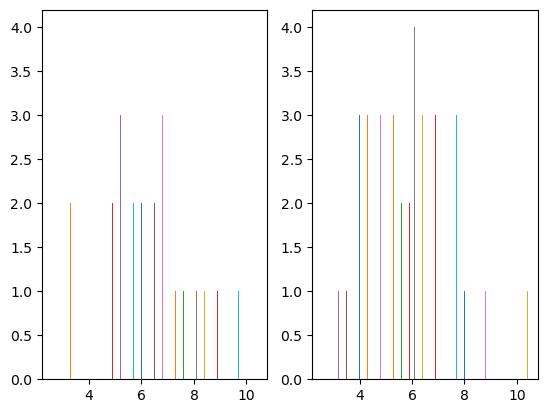

In [ ]:
from matplotlib import pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2)
pos = 0
width = 0.2
for  i in range(10):
    binary_adj = np.random.randint(0,2,(10,10))
    bank_network = nx.from_numpy_array(
                binary_adj,
                parallel_edges=False,
                create_using=nx.DiGraph,
            )  # first define a networkx object.
    ar_in_degree = np.array(bank_network.in_degree())[:,1]
    hist = np.unique(ar_in_degree, return_counts=True)
    ax1.bar(hist[0] + pos, hist[1], width=0.01)
    ax2.bar(hist[0] + pos, hist[1], width=0.01)
    pos = pos +width +0.1



## power low fitting

Calculating best minimal value for power law fit
c:\Users\VictorLeCoz\Anaconda3\envs\interbank_network\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


3.5369177709484454
2.2279074096209066


<Axes: >

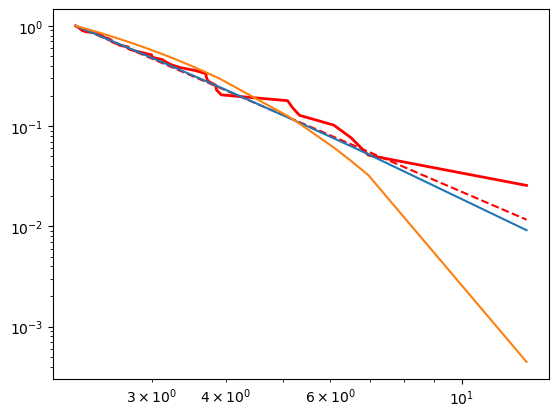

In [ ]:
# fitting
import powerlaw
import numpy as np
sr_data = np.random.pareto(3,size=1000) # data can be list or numpy array
powerlaw_fit = powerlaw.Fit(sr_data)
print(powerlaw_fit.power_law.alpha)
print(powerlaw_fit.power_law.xmin)
R, p = powerlaw_fit.distribution_compare('power_law', 'exponential')
fig2 = powerlaw_fit.plot_ccdf(color = "r", linewidth = 2)
powerlaw_fit.power_law.plot_ccdf(color = "r", linestyle = "--", ax = fig2)
powerlaw_fit.lognormal.plot_ccdf(ax=fig2)
powerlaw_fit.exponential.plot_ccdf(ax=fig2)

## build the calendar

In [ ]:
from workalendar.europe import EuropeanCentralBank

# build the list of holidays
holidays = []
for year in range(2000,2025):
    holidays = holidays + EuropeanCentralBank().holidays(year)

# reformating into a list
holidays = [tuple_day[0] for tuple_day in holidays]
holidays

[datetime.date(2000, 1, 1),
 datetime.date(2000, 4, 21),
 datetime.date(2000, 4, 24),
 datetime.date(2000, 5, 1),
 datetime.date(2000, 12, 25),
 datetime.date(2000, 12, 26),
 datetime.date(2001, 1, 1),
 datetime.date(2001, 4, 13),
 datetime.date(2001, 4, 16),
 datetime.date(2001, 5, 1),
 datetime.date(2001, 12, 25),
 datetime.date(2001, 12, 26),
 datetime.date(2002, 1, 1),
 datetime.date(2002, 3, 29),
 datetime.date(2002, 4, 1),
 datetime.date(2002, 5, 1),
 datetime.date(2002, 12, 25),
 datetime.date(2002, 12, 26),
 datetime.date(2003, 1, 1),
 datetime.date(2003, 4, 18),
 datetime.date(2003, 4, 21),
 datetime.date(2003, 5, 1),
 datetime.date(2003, 12, 25),
 datetime.date(2003, 12, 26),
 datetime.date(2004, 1, 1),
 datetime.date(2004, 4, 9),
 datetime.date(2004, 4, 12),
 datetime.date(2004, 5, 1),
 datetime.date(2004, 12, 25),
 datetime.date(2004, 12, 26),
 datetime.date(2005, 1, 1),
 datetime.date(2005, 3, 25),
 datetime.date(2005, 3, 28),
 datetime.date(2005, 5, 1),
 datetime.date(200

## analysis of ISING reporting in MMSR / underflag of evergreens

In [ ]:
df = df_mmsr_secured.groupby(["report_agent_lei","cntp_lei","trns_nominal_amt","maturity_band"]).agg({"trade_date":lambda x: list(x),"maturity_date":lambda x: list(x)})

In [ ]:
df_mmsr_secured[(df_mmsr_secured["report_agent_lei"]==14701)
                &(df_mmsr_secured["cntp_lei"]==13504)&(df_mmsr_secured["trns_nominal_amt"]==530871213.8)
                ]

,coll_isin,trns_nominal_amt,trns_type,maturity_band,unique_trns_id,trade_date,maturity_date,cntp_lei,report_agent_lei,first_date,start_step,tenor,evergreen
381195,XS0427291751,530871213.8,True,O/N,NaN,2016-05-24,2016-05-25,13504,14701,2016-01-08,95,1,True
391066,XS0427291751,530871213.8,True,O/N,NaN,2016-06-01,2016-06-02,13504,14701,2016-01-08,101,1,True
393207,XS0427291751,530871213.8,True,O/N,NaN,2016-06-02,2016-06-03,13504,14701,2016-01-08,102,1,True
395877,XS0427291751,530871213.8,True,Up to 1W,NaN,2016-06-03,2016-06-04,13504,14701,2016-01-08,103,1,True


In [ ]:
df_mmsr_secured = pd.read_csv(
        f"{path}pickle/df_mmsr_secured.csv", index_col=0
    )
for col in ["trade_date", "maturity_date"]:
        df_mmsr_secured[col] = pd.to_datetime(df_mmsr_secured[col])

C:\Users\VictorLeCoz\AppData\Local\Temp\ipykernel_24776\3848273711.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mmsr_secured = pd.read_csv(


In [ ]:
df = df_mmsr_secured[(df_mmsr_secured["report_agent_lei"]==14701)
                &(df_mmsr_secured["cntp_lei"]==13504)
                ]

## dump 

In [ ]:
import pickle
pickle.dump(
            df_finrep_clean,
            open(f"{path}pickle/df_finrep_clean.pickle", "wb"),
            protocol=pickle.HIGHEST_PROTOCOL,
        )
pickle.dump(
            df_mmsr_unsecured,
            open(f"{path}pickle/df_mmsr_unsecured.pickle", "wb"),
            protocol=pickle.HIGHEST_PROTOCOL,
        )
pickle.dump(
            df_expanded,
            open(f"{path}pickle/df_mmsr_secured_expanded.pickle", "wb"),
            protocol=pickle.HIGHEST_PROTOCOL,
        )
pickle.dump(
            df_mmsr_secured,
            open(f"{path}pickle/df_mmsr_secured.pickle", "wb"),
            protocol=pickle.HIGHEST_PROTOCOL,
        )

## test preprocessing bis for unsecured (not to run)

In [ ]:
# test for unsecured

mmsr_leis = df_mmsr_unsecured["report_agent_lei"].unique()
df_test = df_mmsr_unsecured[df_mmsr_unsecured["cntp_lei"].isin(mmsr_leis)]

path = "./results/empirical_results/test_3/unsecured/"

def get_df_expanded(
    df_clean,
    holidays=False,
    path=False,
    lending=True,
    var_name=False,
):
    """
    This function creates a dataframw where each contract is repeated on each line for each day it is active.
    """

    print("get df_mmsr_secured_expanded")

    # filter only on the reverse repo i.e. lending cash (except user choose the oposite)
    if lending:
        df = df_clean[
            df_clean["trns_type"]
        ]
    else:
        df = df_clean[
            ~df_clean["trns_type"]
        ]
    df.drop("trns_type", axis=1, inplace=True)


    # get the max day from the max of the trade dates
    max_day = max(pd.to_datetime(df["trade_date"]))
    clipped_maturity_date = df["maturity_date"].clip(upper=max_day)

    # Create a list of dates for each contract
    if holidays:
        date_ranges = [
            pd.bdate_range(start, end, freq="C", holidays=holidays)
            for start, end in zip(df["trade_date"], clipped_maturity_date)
        ]
    else:
        date_ranges = [
            pd.date_range(start, end)
            for start, end in zip(df["trade_date"], clipped_maturity_date)
        ]

    # Duplicate rows based on date ranges
    df_expanded = df.loc[
        df.index.repeat([len(dates) for dates in date_ranges])
    ].copy()
    df_expanded["current_date"] = [
        date for dates in date_ranges for date in dates
    ]

    # Reset the index
    df_expanded.reset_index(drop=True, inplace=True)

    # save df_mmsr_secured_clean
    if path:
        df_expanded.to_csv(
            f"{path}pickle/{var_name}.csv"
        )
        pickle.dump(
            df_expanded,
            open(f"{path}pickle/{var_name}.pickle", "wb"),
            protocol=pickle.HIGHEST_PROTOCOL,
        )


    return df_expanded




df_mmsr_unsecured_expanded = get_df_expanded(
    df_clean=df_test,
    holidays=False,
    path=False,
    lending=False,
    var_name="df_mmsr_unsecured_expanded",)
dic_rev_repo_exp_adj = ep.get_dic_rev_repo_exp_adj_from_df_mmsr_secured_expanded(df_mmsr_unsecured_expanded,path=path, plot_period=False)

# get aggregated adjency matrices
dic_arr_binary_adj = ep.get_dic_arr_binary_adj(dic_rev_repo_exp_adj=dic_rev_repo_exp_adj,path=path, plot_period=plot_period)

# get df_rev_repo_trans
df_rev_repo_trans = ep.get_df_rev_repo_trans(df_mmsr_secured_clean, path=path)


get df_mmsr_secured_expanded
get dic_rev_repo_exp_adj from df_mmsr_secured_expanded


100%|██████████| 2468/2468 [00:09<00:00, 265.70it/s]


get dic_arr_binary_adj
get df_rev_repo_trans
